<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Simple Linear Regression with Sacramento Real Estate Data

---

In this lab, you will hone your exploratory data analysis (EDA) skills and practice constructing linear regressions on a data set of Sacramento real estate sales.  The data set contains information on qualities of the property, location of the property, and time of sale.

In [2]:
# Import 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

### 1. Read in the Sacramento housing data set.

The file is stored in the `datasets` subfolder.

In [4]:
sacramento = pd.read_csv ('datasets/sacramento_real_estate_transactions.csv')

### 2. Conduct exploratory data analysis on this data set. 

If you discover any issues with the data, fix them to the best of your ability. **Report any notable findings.**

_**Note:** Zip codes often have leading zeros — e.g., 02215 = Boston, MA — which will often get knocked off automatically by many software programs like Python or Excel._

In [6]:
sacramento.shape

(985, 12)

In [7]:
sacramento.count()

street       985
city         985
zip          985
state        985
beds         985
baths        985
sq__ft       985
type         985
sale_date    985
price        985
latitude     985
longitude    985
dtype: int64

In [8]:
sacramento.head()

,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude
0,3526 HIGH ST,SACRAMENTO,95838,CA,2,1,836,Residential,Wed May 21 00:00:00 EDT 2008,59222,38.631913,-121.434879
1,51 OMAHA CT,SACRAMENTO,95823,CA,3,1,1167,Residential,Wed May 21 00:00:00 EDT 2008,68212,38.478902,-121.431028
2,2796 BRANCH ST,SACRAMENTO,95815,CA,2,1,796,Residential,Wed May 21 00:00:00 EDT 2008,68880,38.618305,-121.443839
3,2805 JANETTE WAY,SACRAMENTO,95815,CA,2,1,852,Residential,Wed May 21 00:00:00 EDT 2008,69307,38.616835,-121.439146
4,6001 MCMAHON DR,SACRAMENTO,95824,CA,2,1,797,Residential,Wed May 21 00:00:00 EDT 2008,81900,38.519470,-121.435768


In [9]:
sacramento.dtypes

street        object
city          object
zip            int64
state         object
beds           int64
baths          int64
sq__ft         int64
type          object
sale_date     object
price          int64
latitude     float64
longitude    float64
dtype: object

In [10]:
sacramento.isnull().sum()

street       0
city         0
zip          0
state        0
beds         0
baths        0
sq__ft       0
type         0
sale_date    0
price        0
latitude     0
longitude    0
dtype: int64

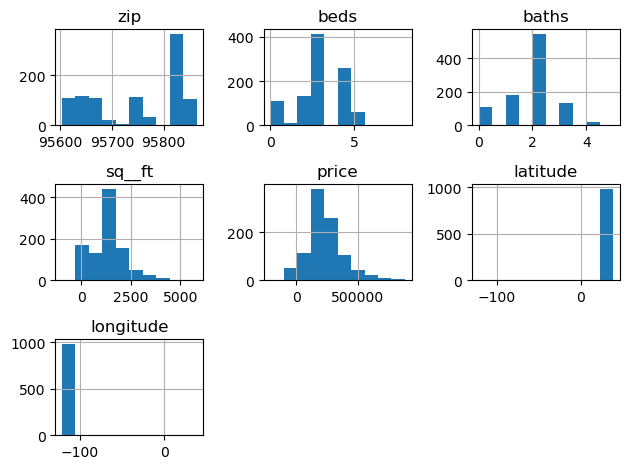

In [11]:
# Let's hist help to get the overview of the skews
sacramento.hist();
plt.tight_layout()

# What the hist tell us...
# There is 0 beds, 0 baths, 0 sqft, 0 and negative price

In [12]:
 #Get the most information from the price as it will be our 'y' or the target
sacramento ['price'].describe()

count       985.000000
mean     233715.951269
std      139088.818896
min     -210944.000000
25%      145000.000000
50%      213750.000000
75%      300000.000000
max      884790.000000
Name: price, dtype: float64

In [13]:
sacramento['city'].unique()

array(['SACRAMENTO', 'RANCHO CORDOVA', 'RIO LINDA', 'CITRUS HEIGHTS',
       'NORTH HIGHLANDS', 'ANTELOPE', 'ELK GROVE', 'ELVERTA', 'GALT',
       'CARMICHAEL', 'ORANGEVALE', 'FOLSOM', 'MATHER', 'POLLOCK PINES',
       'GOLD RIVER', 'EL DORADO HILLS', 'RANCHO MURIETA', 'WILTON',
       'GREENWOOD', 'FAIR OAKS', 'CAMERON PARK', 'LINCOLN', 'PLACERVILLE',
       'MEADOW VISTA', 'ROSEVILLE', 'ROCKLIN', 'AUBURN', 'LOOMIS',
       'EL DORADO', 'PENRYN', 'GRANITE BAY', 'FORESTHILL',
       'DIAMOND SPRINGS', 'SHINGLE SPRINGS', 'COOL', 'WALNUT GROVE',
       'GARDEN VALLEY', 'SLOUGHHOUSE', 'WEST SACRAMENTO'], dtype=object)

In [14]:
# Change zip type as the hint said 'leading zeros' not work well with python
sacramento['zip'] = sacramento['zip'].astype(str) 

In [15]:
# Assume there is mis-spelling. The Sacramento is state in Califonia (CA)
sacramento['state'].value_counts()  

state
CA    984
AC      1
Name: count, dtype: int64

In [16]:
sacramento['state'] = sacramento['state'].str.replace("AC", "CA") # Correct the AC to CA
sacramento['state'].value_counts() # Check work again

state
CA    985
Name: count, dtype: int64

In [17]:
# Rename 'sq__ft' to 'sqft' as easier
sacramento.rename (columns={'sq__ft':'sqft'}, inplace = True) 

In [18]:
# The given data shows there is large number of house that have 0 beds, bath, and sqft. 

In [19]:
# Remove rows where price, sqft, or baths have invalid values
sacramento = sacramento[
    (sacramento['price'] > 0) &
    (sacramento['sqft'] > 0) &
    (sacramento['baths'] > 0)]

The reasons that I remove the invalid price,sqft, and baths because:
1. It is logically wrong. The price, sqft,and the baths cannot be 0 or negative.
2. The nonsens data can produce misleading coefficients or predictions.

The dropped rows is 17% proportion of the total datasets will effect the model predection __BUT__ if still keeps those invalid value will not benefit to the prediction as well.

In [21]:
sacramento['type'].unique()

array(['Residential', 'Condo', 'Multi-Family'], dtype=object)

In [22]:
# Map the 'type' column to numerical values (in case using in the prediction model)
sacramento['type_label'] = sacramento['type'].map({
    'Residential': 1,
    'Condo': 2,
    'Multi-Family': 3
})

# Show the updated data 
sacramento[['type', 'type_label']].head()


,type,type_label
0,Residential,1
1,Residential,1
2,Residential,1
3,Residential,1
4,Residential,1


In [23]:
# After cleaning let's see some correlation for the numeric col.

numeric_columns = sacramento.drop(columns=[
    'street', 'city','state','type','sale_date','latitude','longitude'])

numeric_columns.head() # Check

,zip,beds,baths,sqft,price,type_label
0,95838,2,1,836,59222,1
1,95823,3,1,1167,68212,1
2,95815,2,1,796,68880,1
3,95815,2,1,852,69307,1
4,95824,2,1,797,81900,1


When you've finished cleaning or have made a good deal of progress cleaning, it's always a good idea to save your work. Use the pandas `to_csv` method to export your cleaned dataset.

```python
# example -- your dataframe name may be different
dataframe.to_csv('./datasets/sacramento_cleaned_dataframe.csv', index=False)

```

In [131]:
# Saving clean dataset

#numeric_columns.to_csv('./datasets/sacramento_cleaned_dataframe.csv', index=False)

In [26]:
numeric_columns.columns

Index(['zip', 'beds', 'baths', 'sqft', 'price', 'type_label'], dtype='object')

### 3. Our goal will be to predict price. List variables that you think qualify as predictors of price in an SLR (Simple Linear Regression) model.

For each of the variables you believe should be considered, generate `a plot` showing the `relationship between the independent and dependent` variables.

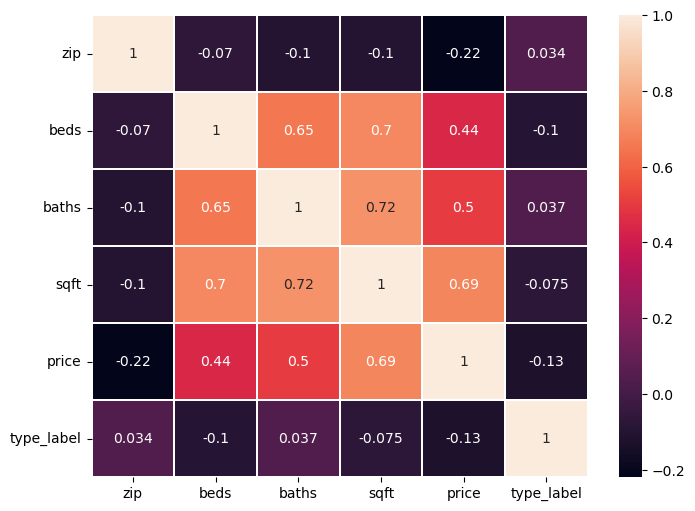

In [28]:
#Throwing our correlation into a heatmap
plt.figure(figsize =(8,6))
sns.heatmap(numeric_columns.corr(), annot = True, linewidth=0.1)
plt.yticks(rotation = 0)
plt.show()

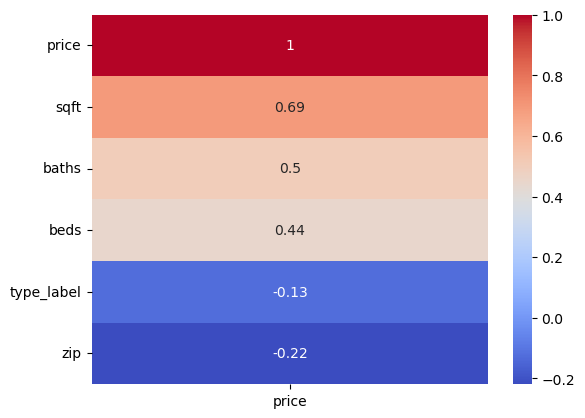

In [29]:
# Have a closer look to see correlation between price and other features.
sns.heatmap(numeric_columns.corr()[['price']].sort_values(by='price',ascending=False), 
            # 'coolwarm' or 'viridis' are better for color - blindness
            cmap='coolwarm', 
            annot = True)
plt.yticks(rotation=0);

In [30]:
# Square feet has high correlation with price in this dataset. 
# Understanding that the bigger area is the more price will be

# The 'beds','baths','sqft','price'	will be X
# 'price' will be target or y

---

### 4. Which variable would be the best predictor of `y` in an SLR (Simple Linear Regression) model? Why?

__Answer__

`price` will be target as in the business term we will target at the price first.

---

### 5. Write a function that will take in two lists, `x` and `y`, and returns the intercept and slope coefficients that minimize SSE (Sum of Squared Errors). 

`y` is the target variable, and `x` is the predictor variable.

**Don't use scikit-learn for this**. Instead, use numpy and scipy.

The slope and intercept of simple linear regression can be calculated by using certain summary statistics. In particular, we'll need to know:

- $\bar{x}$, the mean of `x`
- $\bar{y}$, the mean of `y`
- $s_{x}$, the standard deviation of `x`
- $s_{y}$, the standard deviation of `y`
- $r_{xy}$, the correlation of `x` and `y`

Given these summary statistics, the **coefficient on `X`** (or the slope) can be given by $\beta_{1} = r_{xy} * \frac{s_{y}}{s_{x}}$. The **intercept of the model** can be given by $\beta_{0} = \bar{y} - \beta_{1}\bar{x}$.

Your function should take in `x` and `y`, then use the above summary statistics to calculate the slope and intercept.

- **Test your function on price and the variable you determined was the best predictor in Question #4.**
- **Report the slope and intercept.**

In [36]:
def calculate_slope_intercept(x, y):
    # Convert to numpy arrays for easier calculations
    x = np.array(x)
    y = np.array(y)
    
    # Calculate summary statistics
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    std_x = np.std(x)  
    std_y = np.std(y)
    correlation = np.corrcoef(x, y)[0, 1]
    
    # Calculate slope (b1)
    slope = correlation * (std_y / std_x)
    
    # Calculate intercept (b0)
    intercept = mean_y - (slope * mean_x)
    
    return intercept, slope


price = numeric_columns['price']  
sqft = numeric_columns['sqft']


# Calculate the slope and intercept
intercept, slope = calculate_slope_intercept(sqft, price)

print(f"Intercept: {intercept}, Slope: {slope}")


Intercept: 29984.36172651974, Slope: 125.31418257510143


---

### 6. Now interpret the intercept and the slope.

__Answer:__

`Intercept (b0=29984.36)`
Means that if there were a home with 0 square feet, then the baseline price roughly $29,984.36 


`Slope (b1=125.31)`
The slope indicates how much the price of a home is expected to increase for each additional square foot of space. In this case every 1 unit of square feet is __associated__ with the price of $125.31

__Key Take Away:__ This suggests the bigger area, the higher price will be.


---

### 7. Give an example of how this model could be used for prediction and how it could be used for inference. 

**Be sure to make it clear which example is associated with prediction and which is associated with inference.**

__Answer:__

`Prediction:` Use this model to predict the estimate price of the property based on the square feet (size).

`Inference:` Use this model to understand the impact of the size on home prices.


### 8: Using the model you came up with in Question #5, calculate and plot the residuals.

In [44]:
# Calculate predicted values
predicted = intercept + slope * sqft

# Calculate residuals
residuals = price - predicted

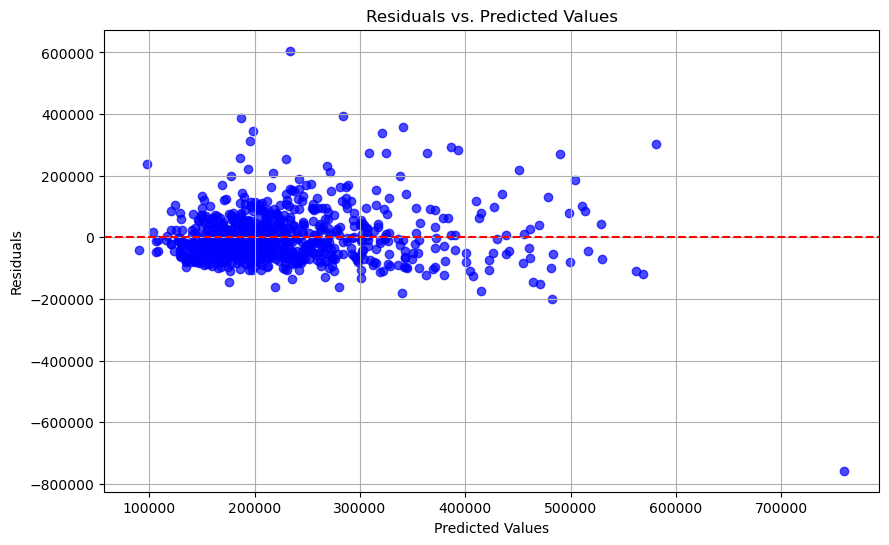

In [45]:
# Plotting residuals vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(predicted, residuals, color='blue', alpha=0.7)
plt.axhline(0, color='red', linestyle='--')  # Add a horizontal line at y=0
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid()
plt.show()

---

## Dummy Variables

It is important to be cautious with categorical variables, which represent distinct groups or categories, when building a regression. If put in a regression "as-is," categorical variables represented as integers will be treated like *continuous* variables.

That is to say, instead of group "3" having a different effect on the estimation than group "1" it will estimate literally 3 times more than group 1. 

For example, if occupation category "1" represents "analyst" and occupation category "3" represents "barista", and our target variable is salary, if we leave this as a column of integers then barista will always have `beta*3` the effect of analyst.

This will almost certainly force the beta coefficient to be something strange and incorrect. Instead, we can re-represent the categories as multiple "dummy coded" columns.



#### A Word of Caution When Creating Dummies

Let's touch on precautions we should take when dummy coding.

**If you convert a qualitative variable to dummy variables, you want to turn a variable with N categories into N-1 variables.**

> **Scenario 1:** Suppose we're working with the variable "sex" or "gender" with values "M" and "F". 

You should include in your model only one variable for "sex = F" which takes on 1 if sex is female and 0 if sex is not female! Rather than saying "a one unit change in X," the coefficient associated with "sex = F" is interpreted as the average change in Y when sex = F relative to when sex = M.

| Female | Male | 
|-------|------|
| 0 | 1 | 
| 1 | 0 |
| 0 | 1 |
| 1 | 0 |
| 1 | 0 |
_As we can see a 1 in the female column indicates a 0 in the male column. And so, we have two columns stating the same information in different ways._

> Scenario 2: Suppose we're modeling revenue at a bar for each of the days of the week. We have a column with strings identifying which day of the week this observation occurred in.

We might include six of the days as their own variables: "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday". **But not all 7 days.**  

|Monday | Tuesday | Wednesday | Thursday | Friday | Saturday | 
|-------|---------|-----------|----------|--------|----------|
| 1     | 0       |0          |      0   |0       | 0        | 
| 0     | 1       |0          |      0   |0       | 0        | 
| 0     | 0       |1          |      0   |0       | 0        | 
| 0     | 0       |0          |      1   |0       | 0        | 
| 0     | 0       |0          |      0   |1       | 0        | 
| 0     | 0       |0          |      0   |0       | 1        | 
| 0     | 0       |0          |      0   |0       | 0        | 

_As humans we can infer from the last row that if its is not Monday, Tuesday, Wednesday, Thursday, Friday or Saturday, it must be Sunday. Models work the same way._

The coefficient for Monday is then interpreted as the average change in revenue when "day = Monday" relative to "day = Sunday." The coefficient for Tuesday is interpreted as the average change in revenue when "day = Tuesday" relative to "day = Sunday" and so on.

The category you leave out, which the other columns are *relative to*, is often referred to as the **reference category**.

### 9. Use the `pd.get_dummies` function to convert the `type` column into dummy-coded variables.

In [48]:
# Create dummy variables
type_dummies = pd.get_dummies(sacramento['type'],prefix = 'type')
type_dummies.sample(n=5,random_state=42) #check work

,type_Condo,type_Multi-Family,type_Residential
273,False,False,True
709,False,False,True
247,False,False,True
334,False,False,True
654,False,False,True


In [49]:
# In the training data we only need 2 dummy variables 
# Because 2 dummies captures all of the "information"
# This case will drop the first col. which wold be 'type_Condo' 
# and it will be use as baseline in the training

type_dummies.drop(type_dummies.columns[0],axis=1, inplace=True)
type_dummies.sample(n=5,random_state=42) #check work

,type_Multi-Family,type_Residential
273,False,True
709,False,True
247,False,True
334,False,True
654,False,True


In [50]:
# Follow the hint do it with 'sale_date'
# Extracting the first three characters of the day from sale_date to get day abbreviation
sacramento['day_of_week'] = sacramento['sale_date'].str[0:3]

# Creating dummy variables for each day of the week with 0/1 encoding
day_of_week_dummies = pd.get_dummies(sacramento['day_of_week'], dtype=int)

# Displaying a random sample of 5 rows from the dummy variable DataFrame
day_of_week_dummies.sample(n=5, random_state=42)

,Fri,Mon,Thu,Tue,Wed
273,0,0,0,1,0
709,1,0,0,0,0
247,0,0,0,1,0
334,0,0,0,1,0
654,1,0,0,0,0


In [51]:
# Concatenate the dummy columns with 'numeric_columns'
numeric_columns = pd.concat([numeric_columns, day_of_week_dummies], axis=1)

# Drop the 'Fri' column from the dummy variables to avoid multicollinearity (k-1 encoding)
numeric_columns.drop('Fri', axis=1, inplace=True)


### 10. Check the dummy columns you've created. Do they all make sense?

Use `.head()` on the new dataframe you've created. Depending on how you cleaned the data earlier in this notebook, there may be a dummy column that needs to be removed. Check that all the columns you've created make sense, and if any of the columns seem to be errors, drop them. If there don't appear to be any errors, then move on to the next step!

In [53]:
numeric_columns.head()

,zip,beds,baths,sqft,price,type_label,Mon,Thu,Tue,Wed
0,95838,2,1,836,59222,1,0,0,0,1
1,95823,3,1,1167,68212,1,0,0,0,1
2,95815,2,1,796,68880,1,0,0,0,1
3,95815,2,1,852,69307,1,0,0,0,1
4,95824,2,1,797,81900,1,0,0,0,1


In [54]:
# Concatenate the dummy columns with 'numeric_columns'
numeric_columns = pd.concat([numeric_columns, type_dummies], axis=1)

# Display the updated DataFrame
numeric_columns.head()

,zip,beds,baths,sqft,price,type_label,Mon,Thu,Tue,Wed,type_Multi-Family,type_Residential
0,95838,2,1,836,59222,1,0,0,0,1,False,True
1,95823,3,1,1167,68212,1,0,0,0,1,False,True
2,95815,2,1,796,68880,1,0,0,0,1,False,True
3,95815,2,1,852,69307,1,0,0,0,1,False,True
4,95824,2,1,797,81900,1,0,0,0,1,False,True


In [55]:
# Drop type_label as we transform it to the get dummies
numeric_columns.drop(columns=['type_label'], inplace=True)

numeric_columns.head() # Check work again

,zip,beds,baths,sqft,price,Mon,Thu,Tue,Wed,type_Multi-Family,type_Residential
0,95838,2,1,836,59222,0,0,0,1,False,True
1,95823,3,1,1167,68212,0,0,0,1,False,True
2,95815,2,1,796,68880,0,0,0,1,False,True
3,95815,2,1,852,69307,0,0,0,1,False,True
4,95824,2,1,797,81900,0,0,0,1,False,True


In [56]:
# type_dummies original is boolean. Let change to int False = 0 and True = 1
# This help putting easier in model

numeric_columns['type_Multi-Family'] = numeric_columns['type_Multi-Family'].apply(lambda x: 1 if x else 0)
numeric_columns['type_Residential'] = numeric_columns['type_Residential'].apply(lambda x: 1 if x else 0)

In [57]:
numeric_columns.head()# Check work again

,zip,beds,baths,sqft,price,Mon,Thu,Tue,Wed,type_Multi-Family,type_Residential
0,95838,2,1,836,59222,0,0,0,1,0,1
1,95823,3,1,1167,68212,0,0,0,1,0,1
2,95815,2,1,796,68880,0,0,0,1,0,1
3,95815,2,1,852,69307,0,0,0,1,0,1
4,95824,2,1,797,81900,0,0,0,1,0,1


### 11. Build what you think may be the best MLR (Multiple Linear Regression) model predicting `price`. 

Choose at least three variables, and build a model that uses them to predict price. At least one of the variables you choose should be a dummy-coded variable. (This can be one we created before or a new one.) 

You may need to load in the scikit-learn API:

```python
from sklearn.linear_model import LinearRegression

model = LinearRegression()
```

In [59]:
# Set up feature_cols
feature_cols = ['sqft','type_Multi-Family','type_Residential']
X = numeric_columns[feature_cols]  # Predictor variables
y = numeric_columns['price']  # Target variable (price)

# Instantiate/Fit Model
lr = LinearRegression()
lr.fit(X,y)

# Evaluate the model by predicting prices 
y_pred = lr.predict(X)


# Model coefficients (intercept and slopes)
print(f"Intercept: {lr.intercept_}")
print(f"Coefficients: {lr.coef_}")


Intercept: 10367.32337468653
Coefficients: [   124.77690915 -41241.36586382  22635.22271999]


In [60]:
# Interpret this as:

# The base price of a condo with 0 sqft and 0 bedrooms is $10,367
# For each additional square foot, the price increases by $124

# If the property is a Multi-Family type, its price will be $41,241 lower than a condo.
# If the property is a Residential type, its price will be $22,635 higher than a condo.

### 12. Plot the true price vs the predicted price to evaluate your MLR (Multiple Linear Regression) visually.

You can use matplotlib or seaborn.

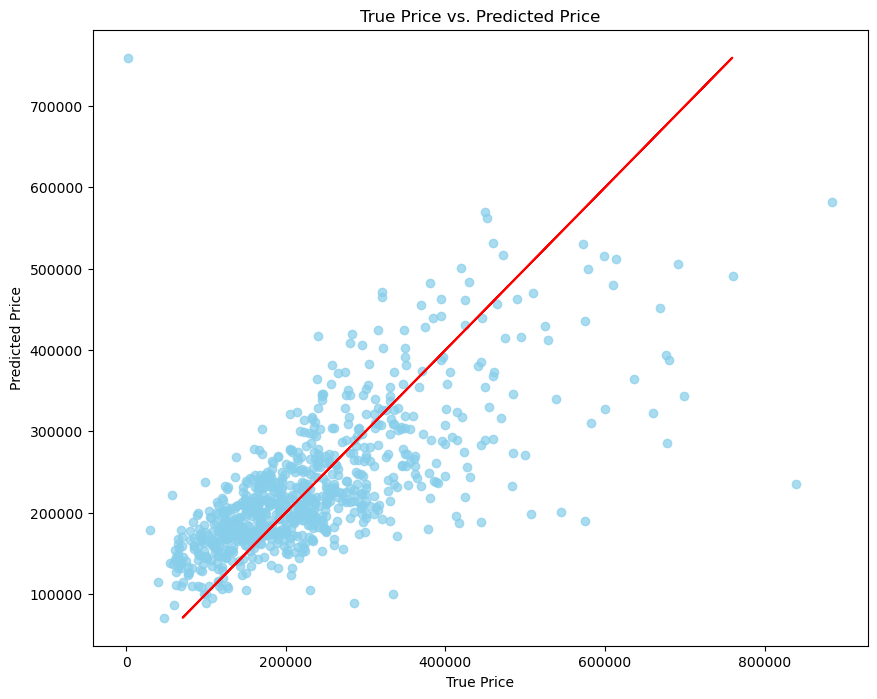

In [62]:
# Plot true prices vs. predicted prices
plt.figure(figsize=(10, 8))
plt.scatter(y, y_pred, alpha=0.7, color='skyblue')  # True prices (y) vs predicted prices (y_pred)
plt.plot(y_pred, y_pred, color='r', linestyle='-')  # Diagonal line

# Add labels and title
plt.xlabel('True Price')
plt.ylabel('Predicted Price')
plt.title('True Price vs. Predicted Price')

# Show the plot
plt.show()


### 13. List the five assumptions for an MLR (Multiple Linear Regression) model. 

Indicate which ones are the same as the assumptions for an SLR model. 

__Answer__

1. Linearity: The independent variables (X) and the dependent variable (y) must have an approximately linear relationship.
2. Independence: Observations are independent of each other.
3. Homoscedasticity: Residuals have constant variance across all levels of independent variables.
4. Normality of Residuals:Residuals should be approximately normally distributed.
5. No Multicollinearity: Independent variables should not be highly correlated with each other.

---

### 14. Pick at least two assumptions and explain whether or not you believe them to be met for your model, and explain why.


`1. Linearity`

Belief: I believe this assumption is likely met for the model.

Explanation:  The X and y appear to have a linear relationship



`2. Independence`

Belief: I do not believe this assumption is likely met for the model.

Explanation: The assumption of independence suggests that the residuals should not be correlated. However, in this case, the positive relationship between square footage (sqft) and price indicates that as sqft increases, prices also rise. This could suggest that there may be patterns in the residuals, which could violate the independence assumption. Therefore, I am concerned that the residuals may not be independent.


---

### 15. [Bonus] Generate a table showing the point estimates, standard errors, t-scores, p-values, and 95% confidence intervals for the model you built. 

**Write a few sentences interpreting some of the output.**

> **Hint:** scikit-learn does not have this functionality built in, but statsmodels does in the `summary` method.  To fit the statsmodels model use something like the following.  There is one big caveat here, however!  `statsmodels.OLS` does _not_ add an intercept to your model, so you will need to do this explicitly by adding a column filled with the number 1 to your X matrix

```python
import statsmodels.api as sm

# The Default here is Linear Regression (ordinary least squares regression OLS)
model = sm.OLS(y,X).fit()
```

In [70]:
import statsmodels.api as sm #importing

In [71]:
feature_cols

['sqft', 'type_Multi-Family', 'type_Residential']

In [72]:
X = numeric_columns[feature_cols]  # Predictor variables
X = sm.add_constant(X) #nly do for statsmodels; creates a new column for a constant value of 1 
y = numeric_columns['price']  # Target variable (price)

# The Default here is Linear Regression (ordinary least squares regression OLS)
model = sm.OLS(y,X)
model = model.fit() #chain "fit()" to the model object
y_pred = model.predict(X) 

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.488
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     256.5
Date:                Mon, 21 Oct 2024   Prob (F-statistic):          5.88e-117
Time:                        00:01:41   Log-Likelihood:                -10389.
No. Observations:                 813   AIC:                         2.079e+04
Df Residuals:                     809   BIC:                         2.080e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              1.037e+04   1.42e+04      0.731      0.465   -1.75e+04    3.82e+04
sqft                124.7769      4.669     26.726      0.000     115.613     133.941
type_Multi-Family -4.124e+04   2.78e+04     -1.482      0.139   -9.59e+04    1.34e+04
type_Residential   2.264e+04   1.41e+04      1.604      0.109   -5056.269    5.03e+04
==============================================================================
Omnibus:                      227.443   Durbin-Watson:                   1.144
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5075.129
Skew:                           0.705   Prob(JB):                         0.00
Kurtosis:                      15.159   Cond. No.                     1.71e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.71e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 16. Regression Metrics

Implement a function called `r2_adj()` that will calculate $R^2_{adj}$ for a model. 

In [74]:
def r2_adj(y, y_pred, total_variables):
   
    r2 = metrics.r2_score(y, y_pred)  # Calculate R-squared
    n = len(y)                              # Number of observations
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - total_variables - 1)  # Calculate Adjusted R-squared

    return r2, adj_r2

In [75]:
# Define the total number of predictor variables
total_variables = X.shape[1]  # Number of predictor variables used in the model

# Calculate R-squared and Adjusted R-squared
r_squared, adjusted_r_squared = r2_adj(y, y_pred, total_variables) 

# Print results
print(f"R-squared: {r_squared}")
print(f"Adjusted R-squared: {adjusted_r_squared}")


R-squared: 0.4875086071825291
Adjusted R-squared: 0.4849715210794723


### 17. Metrics, metrics, everywhere...

Calculate and interpret at least three regression metrics. How well does your model perform?

In [77]:
def regression_metrics(X, y):
    total_variables = X.shape[1]  # Number of predictor variables used in the model
    r_squared, adjusted_r_squared = r2_adj(y, y_pred, total_variables) # Calculate R-squared and Adjusted R-squared

    mae = metrics.mean_absolute_error(y, y_pred)
    mse = metrics.mean_squared_error(y, y_pred)
    rmse = metrics.root_mean_squared_error (y, y_pred)
    # Print metrics
    print(f"R-squared: {r_squared}")
    print(f"Adjusted R-squared: {adjusted_r_squared}")
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Root Mean Square Error (RMSE): {rmse}')
regression_metrics(X, y)

R-squared: 0.4875086071825291
Adjusted R-squared: 0.4849715210794723
Mean Absolute Error (MAE): 59769.605654288185
Mean Squared Error (MSE): 7358221752.361309
Root Mean Square Error (RMSE): 85780.07782907001


##### __Interpret__
The regression model is not good enough. 

MAE - indicating that the model's predictions can be off by around $59,769

MSE -  indicating the potential presence of outliers since there is hugh errors.

RMSE -  indicating an average prediction error of about $85,870

### 18. Model Iteration

Adjust your model by adding or removing a variable. Then calculate the same regression metrics as you used in question 17. Has your model performance increased or decreased?

In [83]:
numeric_columns.columns

Index(['zip', 'beds', 'baths', 'sqft', 'price', 'Mon', 'Thu', 'Tue', 'Wed',
       'type_Multi-Family', 'type_Residential'],
      dtype='object')

In [85]:
feature_cols #check 

['sqft', 'type_Multi-Family', 'type_Residential']

In [117]:
# Define your feature columns
feature_cols = ['sqft', 'type_Multi-Family', 'type_Residential']
feature_cols2 = ['sqft', 'beds', 'baths', 'type_Multi-Family', 'type_Residential']
feature_cols3 = ['beds', 'baths', 'sqft', 'Mon', 'Thu', 'Tue', 'Wed']
feature_cols4 = ['beds', 'baths', 'sqft']
feature_cols5 = ['sqft', 'beds', 'baths', 'Mon', 'Thu', 'Tue', 'Wed', 'zip']
feature_cols6 = ['sqft', 'beds', 'baths','zip']
# Define feature set
feature_sets = [
    (feature_cols, 'Model 1'),
    (feature_cols2, 'Model 2'),
    (feature_cols3, 'Model 3'),
    (feature_cols4, 'Model 4:'),  
    (feature_cols5, 'Model 5:'),
    (feature_cols6, 'Model 6:')
]


In [124]:
# Redefind function as I want to compare  result map with model in the output

def regression_metrics(X, y, model_name):  # Add model name 
    model = LinearRegression()
    model.fit(X, y)                   
    y_pred = model.predict(X)       

    total_variables = X.shape[1]  # Number of predictor variables used in the model
    r_squared, adjusted_r_squared = r2_adj(y, y_pred, total_variables)  # Calculate metrics

    mae = metrics.mean_absolute_error(y, y_pred)
    mse = metrics.mean_squared_error(y, y_pred)
    rmse = metrics.root_mean_squared_error (y, y_pred)
    # Print metrics
       # Print metrics with structured output
    print(f'=========================\n'
          f'Model: {model_name}\n'
          f'Features: {', '.join(X.columns.tolist())}\n'
          f'=========================')
    print(f'R-squared: {r_squared:.4f}')
    print(f'Adjusted R-squared: {adjusted_r_squared:.4f}')
    print(f'Mean Absolute Error (MAE): {mae:.4f}')
    print(f'Mean Squared Error (MSE): {mse:.4f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
    print('\n')

In [126]:
for feature_set, model_name in feature_sets:
    X = numeric_columns[feature_set]  # Predictor variables
    regression_metrics(X, y, model_name)

Model: Model 1
Features: sqft, type_Multi-Family, type_Residential
R-squared: 0.4875
Adjusted R-squared: 0.4856
Mean Absolute Error (MAE): 59769.6057
Mean Squared Error (MSE): 7358221752.3613
Root Mean Squared Error (RMSE): 85780.0778


Model: Model 2
Features: sqft, beds, baths, type_Multi-Family, type_Residential
R-squared: 0.4919
Adjusted R-squared: 0.4888
Mean Absolute Error (MAE): 59088.8648
Mean Squared Error (MSE): 7294706697.5277
Root Mean Squared Error (RMSE): 85409.0551


Model: Model 3
Features: beds, baths, sqft, Mon, Thu, Tue, Wed
R-squared: 0.4966
Adjusted R-squared: 0.4922
Mean Absolute Error (MAE): 59410.0696
Mean Squared Error (MSE): 7228228722.9236
Root Mean Squared Error (RMSE): 85018.9904


Model: Model 4:
Features: beds, baths, sqft
R-squared: 0.4848
Adjusted R-squared: 0.4829
Mean Absolute Error (MAE): 59708.2351
Mean Squared Error (MSE): 7396689989.5154
Root Mean Squared Error (RMSE): 86004.0115


Model: Model 5:
Features: sqft, beds, baths, Mon, Thu, Tue, Wed, z


__Answer__

The comparison shows all 3 metrics (MAE, MSE, and RMSE) changed only a little. This means that even though I tried different sets of features, none of them really improved how accurately I can predict prices. 

`Model 5` have lowest error in all 3 metrics but yet still far from accuracy

### 19. Bias vs. Variance

_(To be completed after the bias-variance tradeoff lecture.)_ At this point, do you think your model is high bias, high variance or in the sweet spot?

__Answer__
All models I have tried has consistently high error rates (MAE, MSE, RMSE) it could indicate __high bias__.